In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import keras
import tensorflow as tf
import statsmodels.api as sm
import seaborn as sns
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
from imblearn.under_sampling import RandomUnderSampler
from sklearn.metrics import roc_curve, auc


##Data Cleaning

In [ ]:
df = pd.read_csv('heart.csv', index_col=None, sep=",")
print(df.head())

   Age Sex ChestPainType  RestingBP  Cholesterol  FastingBS RestingECG  MaxHR  \
0   40   M           ATA        140          289          0     Normal    172   
1   49   F           NAP        160          180          0     Normal    156   
2   37   M           ATA        130          283          0         ST     98   
3   48   F           ASY        138          214          0     Normal    108   
4   54   M           NAP        150          195          0     Normal    122   

  ExerciseAngina  Oldpeak ST_Slope  HeartDisease  
0              N      0.0       Up             0  
1              N      1.0     Flat             1  
2              N      0.0       Up             0  
3              Y      1.5     Flat             1  
4              N      0.0       Up             0  


In [ ]:
print(df.isnull().any().any())  # Check if null values are present in the df

False


In [ ]:
print(df.dtypes) # Check whether the right datatype has been assigned to the variables
print(df.head())

Age                 int64
Sex                object
ChestPainType      object
RestingBP           int64
Cholesterol         int64
FastingBS           int64
RestingECG         object
MaxHR               int64
ExerciseAngina     object
Oldpeak           float64
ST_Slope           object
HeartDisease        int64
dtype: object
   Age Sex ChestPainType  RestingBP  Cholesterol  FastingBS RestingECG  MaxHR  \
0   40   M           ATA        140          289          0     Normal    172   
1   49   F           NAP        160          180          0     Normal    156   
2   37   M           ATA        130          283          0         ST     98   
3   48   F           ASY        138          214          0     Normal    108   
4   54   M           NAP        150          195          0     Normal    122   

  ExerciseAngina  Oldpeak ST_Slope  HeartDisease  
0              N      0.0       Up             0  
1              N      1.0     Flat             1  
2              N      0.0       Up

In [ ]:
# It is necessary to correct the datatype of the variables, based on the value observed in the df

# Categorical variables
df['ChestPainType'] = df['ChestPainType'].astype('category')
df['RestingECG'] = df['RestingECG'].astype('category')
df['ST_Slope'] = df['ST_Slope'].astype('category')

# Binary variables
df['Sex'] = df['Sex'].map({'M': 0, 'F': 1}) # Trasformo la variabile "Sex" in binaria
df['ExerciseAngina'] = df['ExerciseAngina'].map({'N': 0, 'Y': 1})
df['Sex'] = df['Sex'].astype(int)
df['ExerciseAngina'] = df['ExerciseAngina'].astype(int)
df['FastingBS'] = df['FastingBS'].astype(int)
df['HeartDisease'] = df['HeartDisease'].astype(int)


In [ ]:
print(df.dtypes)
print(df.head())

Age                  int64
Sex                  int64
ChestPainType     category
RestingBP            int64
Cholesterol          int64
FastingBS            int64
RestingECG        category
MaxHR                int64
ExerciseAngina       int64
Oldpeak            float64
ST_Slope          category
HeartDisease         int64
dtype: object
   Age  Sex ChestPainType  RestingBP  Cholesterol  FastingBS RestingECG  \
0   40    0           ATA        140          289          0     Normal   
1   49    1           NAP        160          180          0     Normal   
2   37    0           ATA        130          283          0         ST   
3   48    1           ASY        138          214          0     Normal   
4   54    0           NAP        150          195          0     Normal   

   MaxHR  ExerciseAngina  Oldpeak ST_Slope  HeartDisease  
0    172               0      0.0       Up             0  
1    156               0      1.0     Flat             1  
2     98               0      0.0 

In [ ]:
df.describe(include='all') # Show the characteristics of each variable to check for anomalies


,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
count,918.000000,918.000000,918,918.000000,918.000000,918.000000,918,918.000000,918.000000,918.000000,918,918.000000
unique,NaN,NaN,4,NaN,NaN,NaN,3,NaN,NaN,NaN,3,NaN
top,NaN,NaN,ASY,NaN,NaN,NaN,Normal,NaN,NaN,NaN,Flat,NaN
freq,NaN,NaN,496,NaN,NaN,NaN,552,NaN,NaN,NaN,460,NaN
mean,53.510893,0.210240,NaN,132.396514,198.799564,0.233115,NaN,136.809368,0.404139,0.887364,NaN,0.553377
std,9.432617,0.407701,NaN,18.514154,109.384145,0.423046,NaN,25.460334,0.490992,1.066570,NaN,0.497414
min,28.000000,0.000000,NaN,0.000000,0.000000,0.000000,NaN,60.000000,0.000000,-2.600000,NaN,0.000000
25%,47.000000,0.000000,NaN,120.000000,173.250000,0.000000,NaN,120.000000,0.000000,0.000000,NaN,0.000000
50%,54.000000,0.000000,NaN,130.000000,223.000000,0.000000,NaN,138.000000,0.000000,0.600000,NaN,1.000000
75%,60.000000,0.000000,NaN,140.000000,267.000000,0.000000,NaN,156.000000,1.000000,1.500000,NaN,1.000000


##EDA - Exploratory data analysis


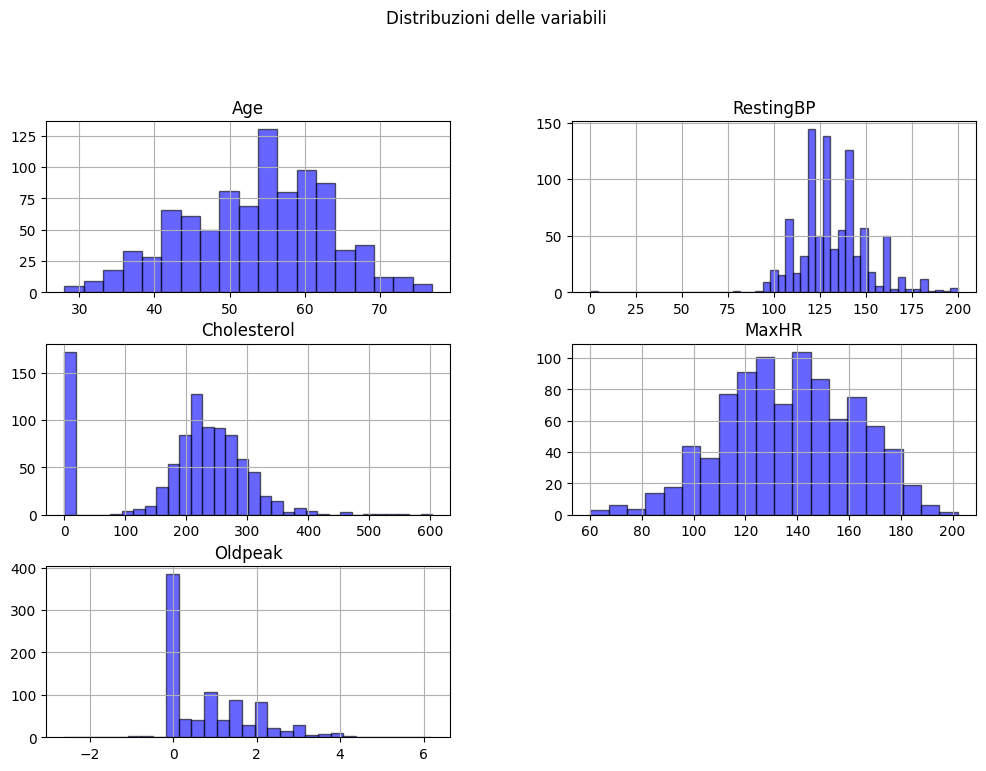

In [ ]:
# Create histograms for selected columns
df[['Age', 'RestingBP', 'Cholesterol', 'MaxHR', 'Oldpeak']].hist(bins='auto', alpha=0.6, color='blue', edgecolor='black', figsize=(12, 8)) # Controlla la distribuzione delle variabili

# Add labels and title
plt.suptitle('Distribuzioni delle variabili', x=0.5, y=1.02, ha='center', fontsize='large')
plt.show()

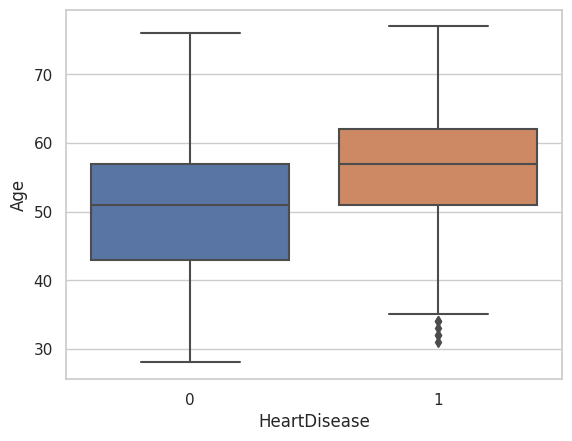

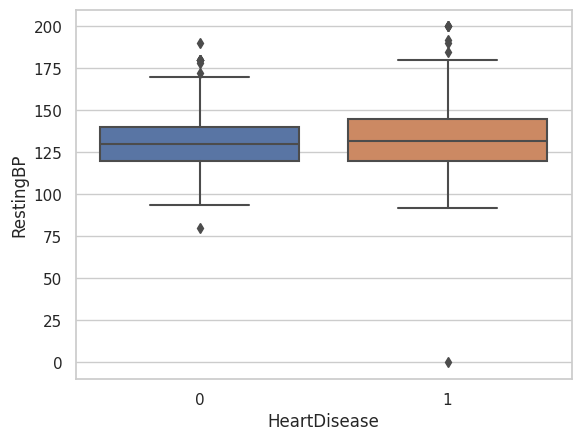

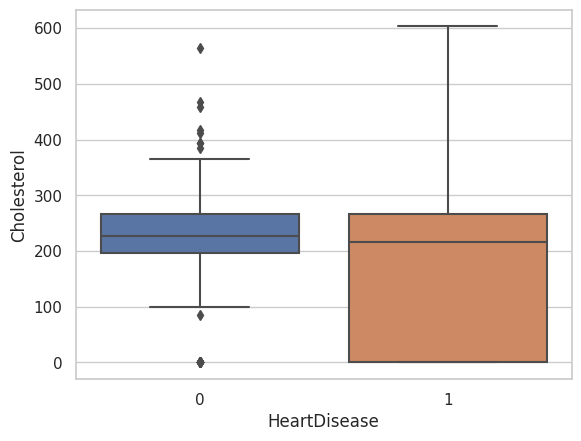

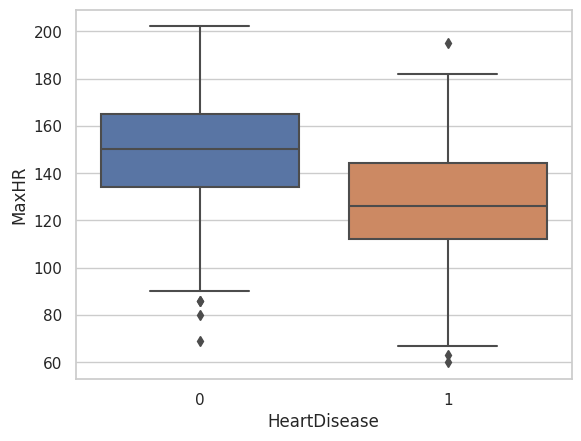

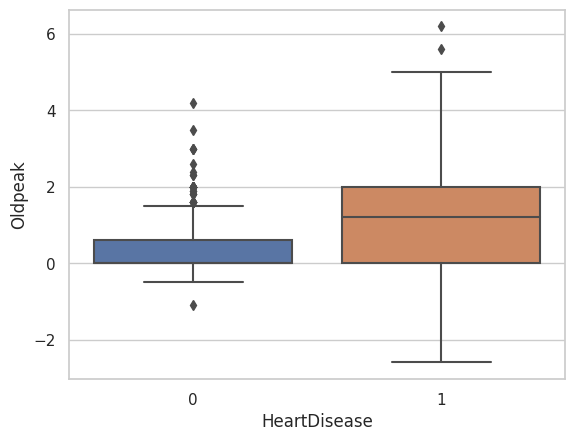

In [ ]:
# Configure seaborn style
sns.set(style="whitegrid")

# Create a unique boxplot for each numeric variable with respect to HeartDisease
sns.boxplot(x='HeartDisease', y='Age', data=df)
plt.show()
sns.boxplot(x='HeartDisease', y='RestingBP', data=df)
plt.show()
sns.boxplot(x='HeartDisease', y='Cholesterol', data=df)
plt.show()
sns.boxplot(x='HeartDisease', y='MaxHR', data=df)
plt.show()
sns.boxplot(x='HeartDisease', y='Oldpeak', data=df)
plt.show()

In [ ]:
# From the boxplot we can see that the variable RestingBP has an unlikely outlier, with value 0
# Locate the df line with this outlier
row_with_zero_resting_bp = df[df['RestingBP'] == 0]

# We print the line with RestingBP at 0
print(row_with_zero_resting_bp)

     Age  Sex ChestPainType  RestingBP  Cholesterol  FastingBS RestingECG  \
449   55    0           NAP          0            0          0     Normal   

     MaxHR  ExerciseAngina  Oldpeak ST_Slope  HeartDisease  
449    155               0      1.5     Flat             1  


In [ ]:
# Remove the row with RestingBP to 0 directly from the DataFrame
df = df[df['RestingBP'] != 0]

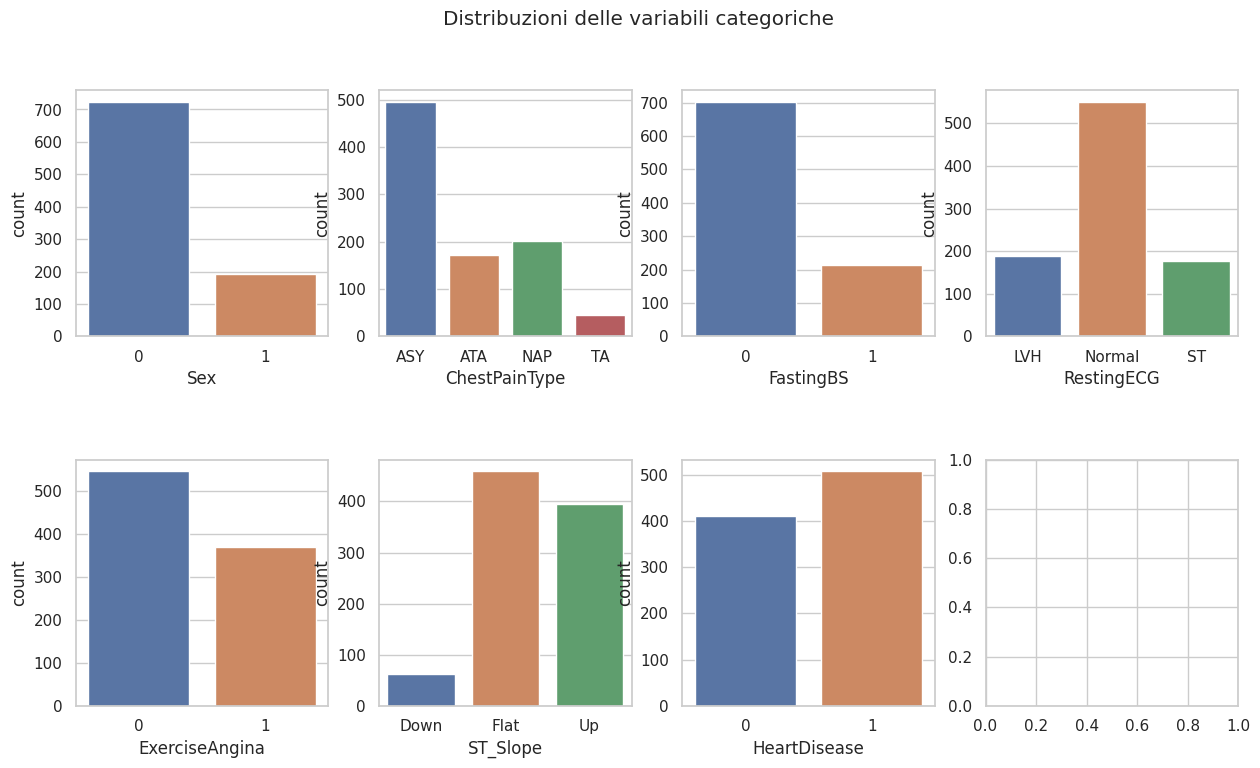

In [ ]:
# Create bar graphs for categorical variables
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(15, 8))

for i, col in enumerate(['Sex', 'ChestPainType', 'FastingBS', 'RestingECG', 'ExerciseAngina', 'ST_Slope', 'HeartDisease']):
    sns.countplot(x=col, data=df, ax=axes[i // 4, i % 4])

# Add space between the two rows of graphs
plt.subplots_adjust(hspace=0.5)

# Aggiungere lo spazio tra le due righe di grafici
fig.suptitle('Distribuzioni delle variabili categoriche', fontsize='large')
plt.show()

In [ ]:
# Check whether the target variable classes are balanced
class_counts = df['HeartDisease'].value_counts()
print("Distribuzione delle classi nella variabile HeartDisease:")
print(class_counts)

# Calculate the percentage of each class
class_percentages = class_counts / class_counts.sum() * 100
print("\nPercentuale di ciascuna classe:")
print(class_percentages)

Distribuzione delle classi nella variabile HeartDisease:
1    507
0    410
Name: HeartDisease, dtype: int64

Percentuale di ciascuna classe:
1    55.288986
0    44.711014
Name: HeartDisease, dtype: float64


In [ ]:
# Undersample class 1 of the target variable
# Create a RandomUnderSampler object
# Specify undersampling strategy
rus = RandomUnderSampler(sampling_strategy={0: 410, 1: 507 - 97}, random_state=42)

# Apply undersampling to features (X) and target variable (y)
X_resampled, y_resampled = rus.fit_resample(df.drop('HeartDisease', axis=1), df['HeartDisease'])

# Create a DataFrame with all original columns and the target variable subsampled
df_resampled = pd.DataFrame(X_resampled, columns=df.drop('HeartDisease', axis=1).columns)
df_resampled['HeartDisease'] = y_resampled

class_counts = df_resampled['HeartDisease'].value_counts()
print("Distribuzione delle classi nella variabile HeartDisease:")
print(class_counts)

Distribuzione delle classi nella variabile HeartDisease:
0    410
1    410
Name: HeartDisease, dtype: int64


In [ ]:
print(df_resampled)

     Age  Sex ChestPainType  RestingBP  Cholesterol  FastingBS RestingECG  \
0     59    0           NAP        180          213          0     Normal   
1     30    1            TA        170          237          0         ST   
2     57    1            TA        130          308          0     Normal   
3     48    0           ATA        100          159          0     Normal   
4     47    0           ASY        140          276          1     Normal   
..   ...  ...           ...        ...          ...        ...        ...   
815   57    0           NAP        128          229          0        LVH   
816   46    0           ASY        115            0          0     Normal   
817   63    0           ASY        185            0          0     Normal   
818   54    0           ASY        120          188          0     Normal   
819   69    0           ASY        135            0          0     Normal   

     MaxHR  ExerciseAngina  Oldpeak ST_Slope  HeartDisease  
0      100    

## Features selection

In [ ]:
# Apply logistic regression with stepwise function
# Select features and target variable
X = pd.get_dummies(df_resampled[['Age', 'Sex', 'ChestPainType', 'RestingBP', 'Cholesterol', 'FastingBS', 'RestingECG', 'MaxHR', 'ExerciseAngina', 'Oldpeak', 'ST_Slope']],
                    columns=['ChestPainType', 'RestingECG', 'ST_Slope']) # Perform one-hot encoding for multiclass categorical variables

y = df_resampled['HeartDisease']  # Target variable

print(X.columns)

Index(['Age', 'Sex', 'RestingBP', 'Cholesterol', 'FastingBS', 'MaxHR',
       'ExerciseAngina', 'Oldpeak', 'ChestPainType_ASY', 'ChestPainType_ATA',
       'ChestPainType_NAP', 'ChestPainType_TA', 'RestingECG_LVH',
       'RestingECG_Normal', 'RestingECG_ST', 'ST_Slope_Down', 'ST_Slope_Flat',
       'ST_Slope_Up'],
      dtype='object')


In [ ]:
from sklearn.linear_model import LogisticRegression

def backward_logistic_regression(X, y, threshold_out, max_iter=2000, tol=1e-4, verbose=False):
    included = list(X.columns)
    while True:
        changed = False
        model = LogisticRegression(max_iter=max_iter, tol=tol)
        model.fit(X[included], y)
        # Get p-values from logistic regression
        pvalues = pd.Series(model.coef_[0], index=included)
        worst_pval = pvalues.max()
        if worst_pval > threshold_out:
            changed = True
            worst_feature = pvalues.idxmax()
            included.remove(worst_feature)
            if verbose:
                print('Drop {:30} with p-value {:.6}'.format(worst_feature, worst_pval))
        if not changed:
            break
    return included

In [ ]:
selected_features = backward_logistic_regression(X, y, threshold_out=0.05, verbose=True)

Drop ChestPainType_ASY              with p-value 1.20247
Drop ST_Slope_Flat                  with p-value 1.30094
Drop FastingBS                      with p-value 1.00346
Drop ExerciseAngina                 with p-value 0.851814
Drop Oldpeak                        with p-value 0.400788
Drop RestingECG_LVH                 with p-value 0.20555


## Rete Neurale

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
print(X.columns)

Index(['Age', 'Sex', 'RestingBP', 'Cholesterol', 'FastingBS', 'MaxHR',
       'ExerciseAngina', 'Oldpeak', 'ChestPainType_ASY', 'ChestPainType_ATA',
       'ChestPainType_NAP', 'ChestPainType_TA', 'RestingECG_LVH',
       'RestingECG_Normal', 'RestingECG_ST', 'ST_Slope_Down', 'ST_Slope_Flat',
       'ST_Slope_Up'],
      dtype='object')


In [ ]:
model = Sequential()
model.add(Dense(32, input_dim=18, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model.add(Dropout(0.2))
model.add(Dense(16, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model.add(Dropout(0.1))
model.add(Dense(8, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])
history = model.fit(X_train, y_train, epochs=900, batch_size=64, validation_data=(X_test, y_test), verbose=1)

Epoch 1/900
9/9 [==============================] - 4s 32ms/step - loss: 19.3154 - accuracy: 0.4913 - val_loss: 11.3709 - val_accuracy: 0.5325
Epoch 2/900
9/9 [==============================] - 0s 8ms/step - loss: 9.5957 - accuracy: 0.4913 - val_loss: 4.6174 - val_accuracy: 0.5325
Epoch 3/900
9/9 [==============================] - 0s 8ms/step - loss: 4.8000 - accuracy: 0.5139 - val_loss: 1.0714 - val_accuracy: 0.6829
Epoch 4/900
9/9 [==============================] - 0s 8ms/step - loss: 3.0707 - accuracy: 0.5592 - val_loss: 2.7801 - val_accuracy: 0.4675
Epoch 5/900
9/9 [==============================] - 0s 10ms/step - loss: 2.7204 - accuracy: 0.5436 - val_loss: 2.2340 - val_accuracy: 0.4675
Epoch 6/900
9/9 [==============================] - 0s 9ms/step - loss: 2.4164 - accuracy: 0.5436 - val_loss: 1.4150 - val_accuracy: 0.4431
Epoch 7/900
9/9 [==============================] - 0s 9ms/step - loss: 2.4968 - accuracy: 0.5226 - val_loss: 1.2281 - val_accuracy: 0.4106
Epoch 8/900
9/9 [======

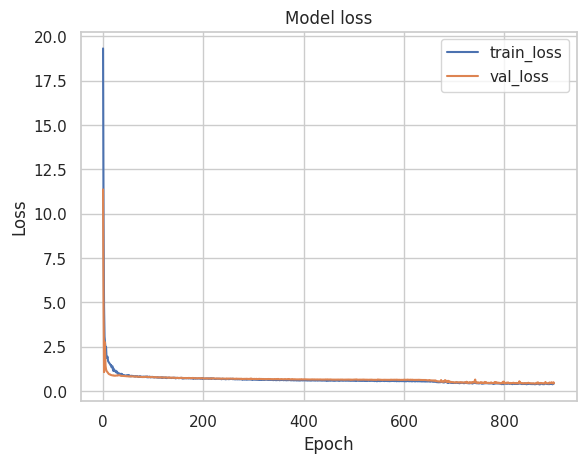

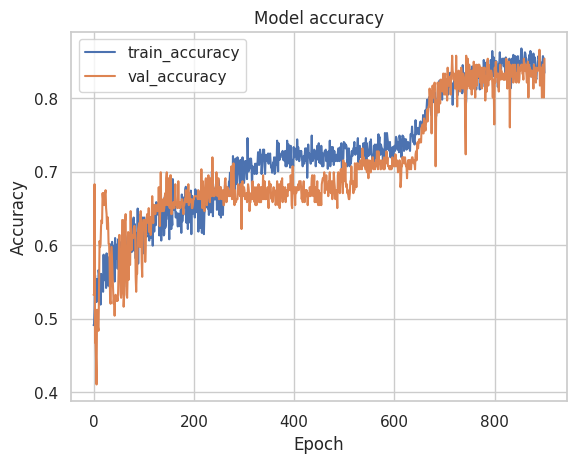

In [ ]:
# Loss curve plot
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Accuracy curve plot
plt.plot(history.history['accuracy'], label='train_accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
# Predicting a new patient
new_patient_data = np.array([[50,0,150,200,0,130,1,2,1,0,0,0,1,0,0,0,0,1]]) # Prevedere un nuovo paziente
prediction = model.predict(new_patient_data)
print(prediction)

1/1 [==============================] - 0s 20ms/step
[[0.7032241]]


## Valutazione del modello






8/8 [==============================] - 0s 3ms/step


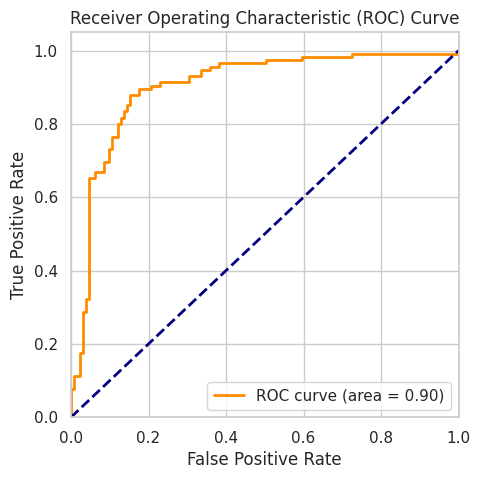

In [ ]:
# Model predictions on the test set
y_pred_prob = model.predict(X_test)

# Calculate the ROC curve and the area under the curve (AUC)
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

# View ROC curve
plt.figure(figsize=(5, 5))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report

# Convert probabilities into binary classes using a threshold
y_pred = (y_pred_prob > 0.4).astype(int)  # the threshold was set at 0.4 to favour the sensitivity of the model

# Calculate the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Extract elements from the confusion matrix
tn, fp, fn, tp = conf_matrix.ravel()

# Calculates sensitivity and specificity
sensitivity = tp / (tp + fn)
specificity = tn / (tn + fp)

# Displays the confusion, sensitivity and specificity matrix
print("Matrice di Confusione:")
print(conf_matrix)
print("\nSensibilità (True Positive Rate): {:.2%}".format(sensitivity))
print("Specificità (True Negative Rate): {:.2%}".format(specificity))

# View classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

Matrice di Confusione:
[[ 98  33]
 [ 10 105]]

Sensibilità (True Positive Rate): 91.30%
Specificità (True Negative Rate): 74.81%

Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.75      0.82       131
           1       0.76      0.91      0.83       115

    accuracy                           0.83       246
   macro avg       0.83      0.83      0.83       246
weighted avg       0.84      0.83      0.82       246



## Final considerations

The AUC (Area Under the Curve) is 0.90, which indicates a good predictive ability of the model.

By default, the threshold is often set at 0.5, which means that all predictions with a probability of more than 50% are classified as positive. However, in some contexts, such as the medical field, you may want to particularly emphasise sensitivity, i.e. the model's ability to correctly identify positive cases.

By reducing the threshold to 0.4, I made the model more prone to classify an instance as positive. This increases sensitivity, but could also lead to an increase in false positives. In the medical field, favouring sensitivity is often a priority to ensure that positive instances (e.g. patients with a particular medical condition) are not overlooked.

Indeed, looking at the confusion matrix, the relatively low number of false negatives (10) detected on the validation set indicates that the model has good sensitivity in detecting the positive class.

